In [1]:
!pip install pycaret

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

from pycaret.classification import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

## 1. 결측치 처리 및 전처리

In [3]:
df = pd.read_csv('./train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### titanic 데이터 정보

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId: 탑승자 데이터 일련번호

Survived: 생존여부, 0 = 사망, 1 = 생존

Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석

Sex: 탑승자 성별

Name: 탑승자 이름

Age: 탑승자 나이

SibSp: 같이 탑승한 형제, 자매 또는 배우자 인원 수

Parch: 같이 탑승한 부모님 또는 자녀 인원 수

Ticket: 티켓 번호

Fare: 요금

Cabin: 선실 번호

Embarked: 탑승 항구, C = Cherbourg, Q = Queenstown, S = Southampton

### Cabin, Embarked 결측치 처리
#### 선실 번호와 탑승 항구의 결측값에 N을 대입한다.

In [5]:
df['Cabin'].fillna('N', inplace=True)
df['Embarked'].fillna('N', inplace=True)

### Age 결측치 처리


#### name을 호칭으로 바꾼 뒤 같은 호칭의 평균으로 결측치를 채운다

In [6]:
df.loc[(df['Name'].str.contains('Mr')) & (~df['Name'].str.contains('Mrs')), 'Name'] = 'Mr'
df.loc[(df['Name'].str.contains('Mrs')), 'Name'] = 'Mrs'
df.loc[(df['Name'].str.contains('Miss')), 'Name'] = 'Miss'
df.loc[(df['Name'].str.contains('Master')), 'Name'] = 'Master'
# 위의 네 호칭이 붙지 않은 사람은 기타(Others)로 분류
df.loc[(~df['Name'].str.contains('Mr')) & (~df['Name'].str.contains('Mrs')) 
       & (~df['Name'].str.contains('Miss')) & (~df['Name'].str.contains('Master')), 'Name'] = 'Others'

In [7]:
# 각 호칭의 갯수
df['Name'].value_counts()

Mr        518
Miss      180
Mrs       129
Master     40
Others     24
Name: Name, dtype: int64

In [8]:
# 호칭별 나이 값의 평균
df.groupby('Name')['Age'].mean()

Name
Master     4.574167
Miss      21.777778
Mr        32.409774
Mrs       35.642857
Others    42.652174
Name: Age, dtype: float64

In [9]:
# 호칭별 나이의 평균을 결측치에 대입
fill_mean_func = lambda x: x.fillna(x.mean())
df = df.groupby('Name').apply(fill_mean_func)

In [10]:
# PassengerId 오름차순으로 dataframe 재정렬
df = df.sort_values(by=['PassengerId'], axis=0)
df.reset_index(drop=True, inplace=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.000000,1,0,A/5 21171,7.2500,N,S
1,2,1,1,Mrs,female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Miss,female,26.000000,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,1,Mrs,female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,Mr,male,35.000000,0,0,373450,8.0500,N,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,Others,male,27.000000,0,0,211536,13.0000,N,S
887,888,1,1,Miss,female,19.000000,0,0,112053,30.0000,B42,S
888,889,0,3,Miss,female,21.777778,1,2,W./C. 6607,23.4500,N,S
889,890,1,1,Mr,male,26.000000,0,0,111369,30.0000,C148,C


In [11]:
# 결측치 처리 완료
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Cabin 전처리

In [12]:
# Cabin 값 분포
df['Cabin'].value_counts()

N                  687
C23 C25 C27          4
G6                   4
B96 B98              4
E101                 3
C22 C26              3
D                    3
F33                  3
F2                   3
B57 B59 B63 B66      2
B35                  2
B51 B53 B55          2
B58 B60              2
B20                  2
B5                   2
D35                  2
E25                  2
E44                  2
F4                   2
D33                  2
B18                  2
C93                  2
D26                  2
C65                  2
C126                 2
E67                  2
B22                  2
C124                 2
C92                  2
C78                  2
B28                  2
C123                 2
E8                   2
B77                  2
D20                  2
D36                  2
F G73                2
E24                  2
B49                  2
D17                  2
C68                  2
C52                  2
E33                  2
C83        

#### Cabin(선실)의 경우 선실 번호 중 선실 등급을 나타내는 첫 번째 알파벳이 중요해 보인다. 왜냐하면 지금보다 부자와 가난한 사람에 대한 차별이 더 있던 시절이었기에 일등실에 투숙한 사람이 삼등실에 투숙한 사람보다 더 살아날 확률이 높았을 것이기 때문이다.

In [13]:
# Cabin 앞 글자만 추출 및 추출 결과
df['Cabin'] = df['Cabin'].str[:1]
df['Cabin'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

## 2. EDA

### 성별에 따른 생존자 그래프 및 분포

In [14]:
# 성별에 따른 생존자 분포
df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

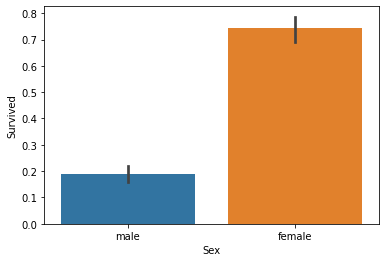

In [15]:
# 성별에 따른 생존자 그래프
sns.barplot(x='Sex', y = 'Survived', data=df)

#### 여자가 남자에 비해 생존 확률이 훨씬 높음을 알 수 있다.

### 선실 등급에 따른 생존 확률

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

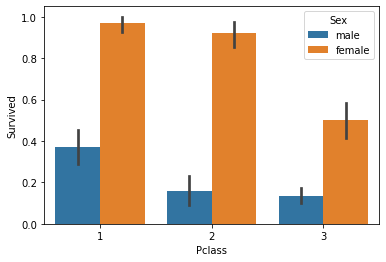

In [16]:
sns.barplot(x='Pclass', y='Survived', hue='Sex',data=df)

#### 일등실의 생존 확률이 삼등실의 생존 확률에 비해 월등히 높다 

### 선실 번호 등급에 따른 생존 확률

<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

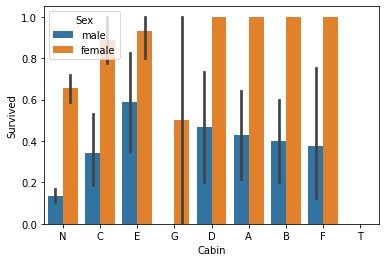

In [17]:
# 선실 번호 등급별 남녀 생존율 그래프
sns.barplot(x='Cabin', y='Survived', hue='Sex',data=df)

In [18]:
# 선실 반호 등급 G에는 여자만 존재
df[df['Cabin']=='G']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,11,1,3,Miss,female,4.0,1,1,PP 9549,16.7000,G,S
205,206,0,3,Miss,female,2.0,0,1,347054,10.4625,G,S
251,252,0,3,Mrs,female,29.0,1,1,347054,10.4625,G,S
394,395,1,3,Mrs,female,24.0,0,2,PP 9549,16.7000,G,S


In [19]:
# 선실 반호 등급 T의 탑승객은 모두 죽음
df[df['Cabin']=='T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,Mr,male,45.0,0,0,113784,35.5,T,S


G : 여성만 있는 선실

T : 1명의 탑승객이 존재하나 모두 죽음

선실 번호 등급이 알려지지 않은 사람(N)의 생존율이 낮은 편

In [20]:
# 선실 번호 등급이 알려지지 않은 사람(N)의 선실 등급 평균이 2.639010으로 높은 편임을 알 수 있다.
df.groupby('Cabin')['Pclass'].mean().sort_values(ascending=False)

Cabin
G    3.000000
N    2.639010
F    2.384615
E    1.312500
D    1.121212
T    1.000000
C    1.000000
B    1.000000
A    1.000000
Name: Pclass, dtype: float64

### 탑승자 호칭에 따른 생존자 그래프 및 분포

In [21]:
# 탑승자 호칭에 따른 생존자 분포
df.groupby(['Name', 'Survived'])['Survived'].count()

Name    Survived
Master  0            17
        1            23
Miss    0            54
        1           126
Mr      0           436
        1            82
Mrs     0            27
        1           102
Others  0            15
        1             9
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Name', ylabel='Survived'>

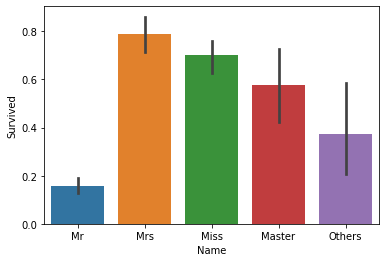

In [22]:
# 탑승자 호칭에 따른 생존자 그래프
sns.barplot(x='Name', y ='Survived', data=df)

<AxesSubplot:xlabel='Name', ylabel='Survived'>

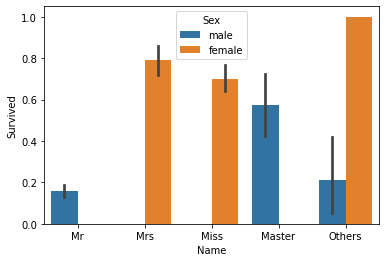

In [23]:
# 탑승자 호칭에 따른 남녀 생존자 그래프
sns.barplot(x='Name', y ='Survived', hue='Sex', data=df)

Mr의 사망 확률이 높은 편이다. (518명중 436명 사망)

남자의 생존 확률이 낮음을 알 수 있다.

### 나이에 따른 생존 확률

In [24]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
        
    return cat



<AxesSubplot:xlabel='Age_cat', ylabel='Survived'>

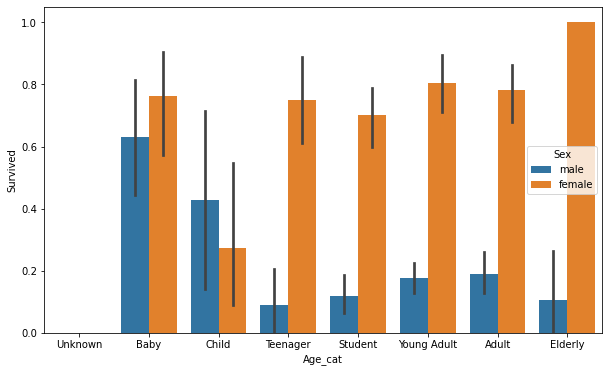

In [25]:
plt.figure(figsize=(10, 6))

# X축의 값 순서 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식을 사용해 age를 category로 변환
df['Age_cat'] = df['Age'].apply(lambda x: get_category(x))
# 나이 카테고리, 성별 그룹별 생존률 그래프
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=df, order=group_names)
# df.drop('Age_cat', axis=1, inplace=True)

In [26]:
# 나이 카테고리, 성별 그룹별 생존 분포
print(df.groupby(['Age_cat', 'Sex', 'Survived'])['Survived'].count())
# Age_cat 열 제거
df.drop('Age_cat', axis=1, inplace=True)

Age_cat      Sex     Survived
Adult        female  0            19
                     1            68
             male    0           102
                     1            24
Baby         female  0             5
                     1            16
             male    0            10
                     1            17
Child        female  0             8
                     1             3
             male    0             8
                     1             6
Elderly      female  1             3
             male    0            17
                     1             2
Student      female  0            27
                     1            63
             male    0            95
                     1            13
Teenager     female  0             9
                     1            27
             male    0            31
                     1             3
Young Adult  female  0            13
                     1            53
             male    0           205
        

여자 

Child는 다른 연령대에 비해 생존 확률 낮음

Elderly는 생존 확률 매우 높음(전부 생존)

남자

Teenager 이상의 생존 확률 매우 낮음

### 같이 탑승한 형제 자매, 배우자 인원 수에 따른 생존 확률

In [27]:
# 같이 탑승한 형제 자매, 배우자 인원 수에 따른 생존자 분포
df.groupby(['SibSp', 'Sex', 'Survived'])['Survived'].count()

SibSp  Sex     Survived
0      female  0            37
               1           137
       male    0           361
               1            73
1      female  0            26
               1            80
       male    0            71
               1            32
2      female  0             3
               1            10
       male    0            12
               1             3
3      female  0             7
               1             4
       male    0             5
4      female  0             4
               1             2
       male    0            11
               1             1
5      female  0             1
       male    0             4
8      female  0             3
       male    0             4
Name: Survived, dtype: int64

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

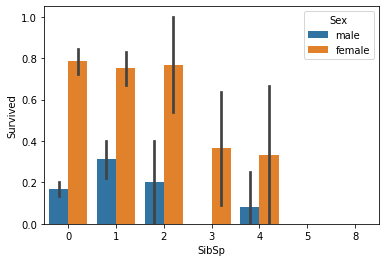

In [28]:
# 같이 탑승한 형제 자매, 배우자 인원 수에 따른 생존자 그래프
sns.barplot(x='SibSp', y='Survived', hue='Sex', data=df)

형제 자매 및 배우자 인원 수가 많을수록 생존확률 낮다.

남자의 경우 SibSp 값이 3 이상이면 거의 살아남지 못했다.

### 같이 탑승한 부모님, 자녀 수에 따른 생존 확률

In [29]:
# 같이 탑승한 부모님, 자녀 수에 따른 생존자 분포
df.groupby(['Parch', 'Sex', 'Survived'])['Survived'].count()

Parch  Sex     Survived
0      female  0            41
               1           153
       male    0           404
               1            80
1      female  0            14
               1            46
       male    0            39
               1            19
2      female  0            19
               1            30
       male    0            21
               1            10
3      female  0             1
               1             3
       male    0             1
4      female  0             2
       male    0             2
5      female  0             3
               1             1
       male    0             1
6      female  0             1
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

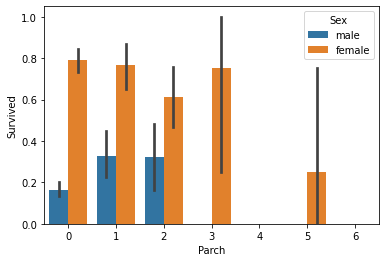

In [30]:
# 같이 탑승한 부모님, 자녀 인원 수에 따른 생존자 그래프
sns.barplot(x='Parch', y='Survived', hue='Sex', data=df)

딸린 부모님 및 자녀 인원 수가 많을수록 생존확률 낮다.

남자의 경우 Parch 값이 3 이상이면 살아남지 못했다.

## 3. 라벨 인코딩

In [31]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,N,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,N,S


In [32]:
# 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환
def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked', 'Name']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

df = encode_features(df)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,2,1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,3,0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,1,0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,3,0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,2,1,35.0,0,0,373450,8.0500,7,3


In [33]:
# 머신러닝 알고리즘에 불필요한 속성 제거
df.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

In [34]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,2,1,22.0,1,0,7.2500,7,3
1,1,1,3,0,38.0,1,0,71.2833,2,0
2,1,3,1,0,26.0,0,0,7.9250,7,3
3,1,1,3,0,35.0,1,0,53.1000,2,3
4,0,3,2,1,35.0,0,0,8.0500,7,3


## 4. 모델 학습 및 파라미터 서치

### AutoML로 정확도 가장 높은 모델 찾기

In [35]:
# 환경 설정
clf = setup(data = df, target = 'Survived', session_id = 123, silent = True) 

,Description,Value
0,session_id,123
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(891, 10)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [36]:
# 모델들의 정확도 출력
compare_models(sort = 'Accuracy', n_select = 1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8250,0.8562,0.7087,0.8208,0.7589,0.6230,0.6284,0.0140
catboost,CatBoost Classifier,0.8202,0.8671,0.7217,0.8020,0.7579,0.6158,0.6195,0.5080
lda,Linear Discriminant Analysis,0.8043,0.8520,0.7177,0.7687,0.7414,0.5844,0.5861,0.0050
lr,Logistic Regression,0.8026,0.8556,0.7257,0.7637,0.7426,0.5828,0.5849,0.5060
ada,Ada Boost Classifier,0.8026,0.8459,0.7667,0.7414,0.7520,0.5883,0.5906,0.0160
ridge,Ridge Classifier,0.8011,0.0000,0.7137,0.7648,0.7374,0.5777,0.5795,0.0060
lightgbm,Light Gradient Boosting Machine,0.7913,0.8571,0.6880,0.7648,0.7194,0.5545,0.5604,0.0250
xgboost,Extreme Gradient Boosting,0.7897,0.8478,0.7007,0.7577,0.7228,0.5544,0.5599,0.1290
rf,Random Forest Classifier,0.7880,0.8637,0.7212,0.7376,0.7259,0.5537,0.5569,0.0420
et,Extra Trees Classifier,0.7785,0.8425,0.7015,0.7281,0.7111,0.5322,0.5357,0.0380


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### 모델 학습 및 예측

In [37]:
# 학습 데이터 feature와 label 분리
y_df = df['Survived']
X_df = df.drop('Survived', axis=1)

In [38]:
# train, test 데이터 세트 분류
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11)

In [39]:
# gradient boost, random forest, AdaBoostClassifier를 위한 사이킷런 classifier 클래스 생성
gbc_clf = GradientBoostingClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
ada_clf = AdaBoostClassifier(random_state=11)

# GradientBoostingClassifier 학습,예측,정확도 출력
gbc_clf.fit(X_train, y_train)
gbc_pred = gbc_clf.predict(X_test)
print('GradientBoostingClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, gbc_pred)))

# RandomForestClassifier 학습,예측,정확도 출력
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# AdaBoostClassifier 학습,예측,정확도 출력
ada_clf.fit(X_train, y_train)
ada_pred = ada_clf.predict(X_test)
print('AdaBoostClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

GradientBoostingClassifier 정확도: 0.8715
RandomForestClassifier 정확도: 0.8492
AdaBoostClassifier 정확도: 0.8659


In [40]:
# kfold 사용
def exec_kfold(clf, folds=5):
    # 폴드 세트가 5개인 KFold 객체 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 생성
    kfold = KFold(n_splits=folds)
    scores = []
    
    # kFold 교차 검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_df)):
        # X_df, y_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_df.values[train_index], X_df.values[test_index]
        y_train, y_test = y_df.values[train_index], y_df.values[test_index]
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도:  {1:.4f}".format(iter_count, accuracy))
        
    # 5개 fold에서의 평균 정확도 계산.
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))
        
# exec_kfold 호출
exec_kfold(gbc_clf, folds=5)

교차 검증 0 정확도:  0.8380
교차 검증 1 정확도:  0.7978
교차 검증 2 정확도:  0.8258
교차 검증 3 정확도:  0.7753
교차 검증 4 정확도:  0.8820
평균 정확도: 0.8238


In [41]:
# cross_val_score 사용
scores = cross_val_score(gbc_clf, X_df, y_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.8324
교차 검증 1 정확도: 0.7978
교차 검증 2 정확도: 0.8483
교차 검증 3 정확도: 0.8090
교차 검증 4 정확도: 0.8764
평균 정확도: 0.8328


### 파라미터 서치

In [42]:
# GradientBoostingClassifier 파라미터 서치
params = {
    'n_estimators' : [100, 200, 500],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [3, 5, 7, 10],
    'min_samples_split' : [2, 3, 5, 10],
    'learning_rate' : [0.05, 0.1, 0.2]
}
grid_cv = GridSearchCV(gbc_clf, param_grid=params, scoring="accuracy", n_jobs=-1, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.7min


최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
최고 예측 정확도: 0.8287


[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  2.1min finished


In [43]:
# GridSearchCV를 이용해 최적으로 학습된 estimator로 예측 수행.
gbc_pred = grid_cv.best_estimator_.predict(X_test)
gbc_accuracy = accuracy_score(y_test, gbc_pred)
print("GradientBoostingClassifier GridSearch 정확도: {0:.4f}".format(gbc_accuracy))

GradientBoostingClassifier GridSearch 정확도: 0.8939


### 앙상블 수행

In [44]:
# GradientBoostingClassifier GridSearchCV 모델을 base_esimator로 한 앙상블 모델 비교

gbc_bagging_clf = BaggingClassifier(base_estimator=grid_cv.best_estimator_, n_estimators=10, random_state=0)
gbc_bagging_clf.fit(X_train, y_train)
gbc_bagging_pred = gbc_bagging_clf.predict(X_test)
gbc_bagging_accuracy = accuracy_score(y_test, gbc_bagging_pred)
print("GradientBoostingClassifier Bagging 정확도: {0:.4f}".format(gbc_bagging_accuracy))

gbc_ada_clf = AdaBoostClassifier(base_estimator=grid_cv.best_estimator_, n_estimators=10, random_state=0)
gbc_ada_clf.fit(X_train, y_train)
gbc_ada_pred = gbc_ada_clf.predict(X_test)
gbc_ada_accuracy = accuracy_score(y_test, gbc_ada_pred)
print("GradientBoostingClassifier Adaboost 정확도: {0:.4f}".format(gbc_ada_accuracy))

GradientBoostingClassifier Bagging 정확도: 0.8883
GradientBoostingClassifier Adaboost 정확도: 0.8380


In [45]:
# GradientBoostingClassifier와 AdaBoostClassifier 보팅(하드)
vo_hard_clf = VotingClassifier( estimators=[('GBC', grid_cv.best_estimator_), ('ADA', ada_clf)])

# VotingClassifier 학습, 예측, 정확도 계산
vo_hard_clf.fit(X_train, y_train)
hard_pred = vo_hard_clf.predict(X_test)
print('VotingClassifier Hard 정확도: {0:.4f}'.format(accuracy_score(y_test, hard_pred)))

VotingClassifier Hard 정확도: 0.8827


In [46]:
# GradientBoostingClassifier와 AdaBoostClassifier 보팅(소프트)
vo_soft_clf = VotingClassifier( estimators=[('GBC', grid_cv.best_estimator_), ('ADA', ada_clf)], voting='soft')

# VotingClassifier 학습, 예측, 정확도 계산
vo_soft_clf.fit(X_train, y_train)
soft_pred = vo_soft_clf.predict(X_test)
print('VotingClassifier Soft 정확도: {0:.4f}'.format(accuracy_score(y_test, soft_pred)))

VotingClassifier Soft 정확도: 0.8939
